In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import types

from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
from tsnecuda import TSNE
from torch.distributions import Bernoulli, Normal
from torchvision.utils import save_image

from data.load_data import load_onehot, load_binary_mnist
from ex_siren_vae_flow_effect import XencodingInferNetwork, MNISTConvEncoder, MNISTConvDecoder
from siren_vae_explorations_utils import *

In [3]:
device = "cpu" if not(torch.cuda.is_available()) else "cuda:0" 

# Benefit of the Flow Prior and Variational Posterior

### Some Utilities

In [4]:
def elbo_curves(experiments, legend, _config):
    num_runs = _config['num_runs']
    iter = _config['iter']
    ylims = _config['ylims']
    log_scale = _config['log_scale']
    path = './experiment_logs/'
    exs_data = {'names':[]}
    num_experiments = len(experiments)
    palette = _config['palette'][:num_experiments]

    for p in range(num_experiments):
        ex_name = experiments[p]
        exs_data['names'].append(ex_name)
        
        for i in range(1,num_runs+1):
            with open(os.path.join(path, experiments[p], str(i), 'metrics.json')) as json_file:
                data = json.load(json_file)
                
                if p == 0 and i == 1:
                    exs_data['iter'] = data['train.elbo']['steps'][:iter]
                    num_iters = len(data['train.elbo']['steps'][:iter])
                    exs_data['elbo'] = np.zeros((num_iters, num_runs*num_experiments))
                    exs_data['val elbo'] = np.zeros((num_iters, num_runs*num_experiments))

                exs_data['elbo'][:,p*num_runs+i-1] = data['train.elbo']['values'][:iter]
                exs_data['val elbo'][:,p*num_runs+i-1] = data['val.elbo']['values'][:iter]

    columns = [[], []]
    for ex_name in exs_data['names']:
        columns[0] += [ex_name]*num_runs
        for i in range(1, num_runs+1):
            columns[1] += ['run_'+str(i)]
    columns = list(zip(*columns))
    columns = pd.MultiIndex.from_tuples(columns, names=["experiment", "runs"])

    # Training shifted reverse kl-divergence
    df = pd.DataFrame(exs_data['elbo'], index=exs_data['iter'], columns=columns)
    df = df.unstack(level=1).reset_index()
    s = sns.lineplot(data=df, x='level_2', y=0, hue='experiment',
        palette=palette)
    if log_scale:
        s.set(yscale='log')
    plt.ylabel('Train Negative ELBO')
    plt.xlabel('epoch')
    if ylims is not None:
        plt.ylim(ylims[0])
    plt.legend(legend)
    plt.show()

    # Test shifted reverse kl-divergence
    df = pd.DataFrame(exs_data['val elbo'], index=exs_data['iter'], columns=columns)
    df = df.unstack(level=1).reset_index()
    s = sns.lineplot(data=df, x='level_2', y=0, hue='experiment',
        palette=palette)
    if log_scale:
        s.set(yscale='log')
    plt.ylabel('Validation Negative ELBO')
    plt.xlabel('epoch')
    if ylims is not None:
        if len(ylims) > 1:
            plt.ylim(ylims[1])
        else:
            plt.ylim(ylims[0])
    plt.legend(legend)
    plt.show()

In [5]:
def get_units_variances(model, x, num_latent):
    means = torch.zeros((x.shape[0],num_latent))
    
    # sample z
    for i in range(x.shape[0]):
        xi = x[i].expand(500,-1)
        z, _ = model.inference_network(xi)
        means[i] = torch.mean(z,dim=0)
    
    vars_of_means = torch.var(means, dim=0)
    
    return vars_of_means

In [6]:
def importance_sampled_log_likelihood(model, x, k, batch_size, device):
    ll = 0
    data = torch.utils.data.DataLoader(x, batch_size=batch_size)
    for batch in data:
        ll += torch.mean(model.importance_sampled_log_likelihood(batch.to(device), k))
    return ll/(x.shape[0]//batch_size)

In [7]:
# replacement - backward compatability
def forward(self, x, z):
    # Compute the density of z
    if hasattr(self, 'prior'):
        log_p_z = self.prior(z)
    else:
        _, log_p_z = self.nf(z)

    # Calculate mean and standard deviation 
    params = self.decoder_net(z)

    p = Bernoulli(probs=torch.sigmoid(params))

    # Compute the obs likelihood
    log_p_x_given_z = p.log_prob(x).sum(dim=1)
    return log_p_x_given_z, log_p_z

def sample(self, batch_size):
    # Generate sample of latent variables
    z = Normal(
        loc=torch.zeros(self.latent_dim), 
        scale=torch.ones(self.latent_dim)
        ).sample((batch_size,)).to(self.device)

    if hasattr(self, 'nf'):
        z, _ = self.nf.inverse(z)

    # Calculate mean and standard deviation 
    params = self.decoder_net(z)
    return torch.sigmoid(params), z

def attach_bernoulli_forward(model):
    model.generative_network.forward = types.MethodType(forward, model.generative_network)

def attach_bernoulli_sample(model):
    model.generative_network.sample = types.MethodType(sample, model.generative_network)



## One-hot Dataset

In [10]:
# Train Vanilla VAE
! python ./ex_siren_vae_flow_effect.py with dataset=onehot lr=1e-2 num_epochs=200 num_latent=2 patience=20 vae_hidden_dims='[100]' num_blocks=5 num_train_samples=5000 num_val_samples=1000 seed=1 flow_hidden_dims='[100]'

INFO - SIReN-VAE Ablation Study - Running command 'run'
INFO - SIReN-VAE Ablation Study - Started run with ID "2"
Train ELBO: 2.075, Test ELBO: 2.057: 100%|██████████| 200/200 [00:41<00:00,  4.85it/s]
INFO - SIReN-VAE Ablation Study - Completed after 0:00:43


In [11]:
# Train VAE + GRF-posterior
! python ./ex_siren_vae_flow_effect.py with dataset=onehot lr=1e-2 num_epochs=200 num_latent=2 patience=20 vae_hidden_dims='[100]' num_blocks=5 num_train_samples=5000 num_val_samples=1000 seed=1 flow_hidden_dims='[100]' add_grf_posterior=True fc_bn=True indep_bn=False

INFO - SIReN-VAE Ablation Study - Running command 'run'
INFO - SIReN-VAE Ablation Study - Started run with ID "1"
Train ELBO: 1.675, Test ELBO: 1.686: 100%|██████████| 200/200 [07:05<00:00,  2.13s/it]
INFO - SIReN-VAE Ablation Study - Completed after 0:07:07


In [21]:
# Train VAE + GRF-posterior + GRF-prior
! python ./ex_siren_vae_flow_effect.py with dataset=onehot lr=1e-2 num_epochs=200 num_latent=2 patience=20 vae_hidden_dims='[100]' num_blocks=5 num_train_samples=5000 num_val_samples=1000 seed=4 flow_hidden_dims='[100]' add_grf_posterior=True fc_bn=True indep_bn=False add_grf_prior=True

INFO - SIReN-VAE Ablation Study - Running command 'run'
INFO - SIReN-VAE Ablation Study - Started run with ID "5"
Train ELBO: 1.637, Test ELBO: 1.633: 100%|██████████| 200/200 [13:44<00:00,  4.12s/it]
INFO - SIReN-VAE Ablation Study - Completed after 0:13:46


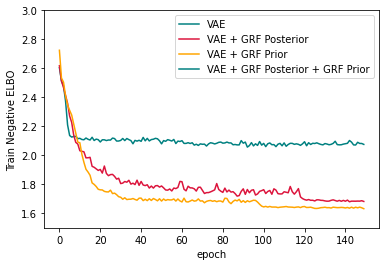

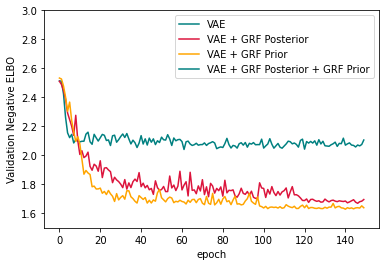

In [23]:
plt.rcParams.update({'font.size': 10})
elbo_curves(
    experiments=[
        'SIReN-VAE_flow_effect/onehot/VAE/',
        'SIReN-VAE_flow_effect/onehot/VAE_GRF-post/',
        'SIReN-VAE_flow_effect/onehot/VAE_GRF-post_GRF-prior/'],
    legend=['VAE', 'VAE + GRF Posterior', 'VAE + GRF Prior', 'VAE + GRF Posterior + GRF Prior'],
    _config={
        'num_runs':1,
        'iter':150,
        'ylims':[(1.5,3)],
        'log_scale':False,
        'palette':('teal','crimson', 'orange', 'darkslateblue', 'slateblue')})

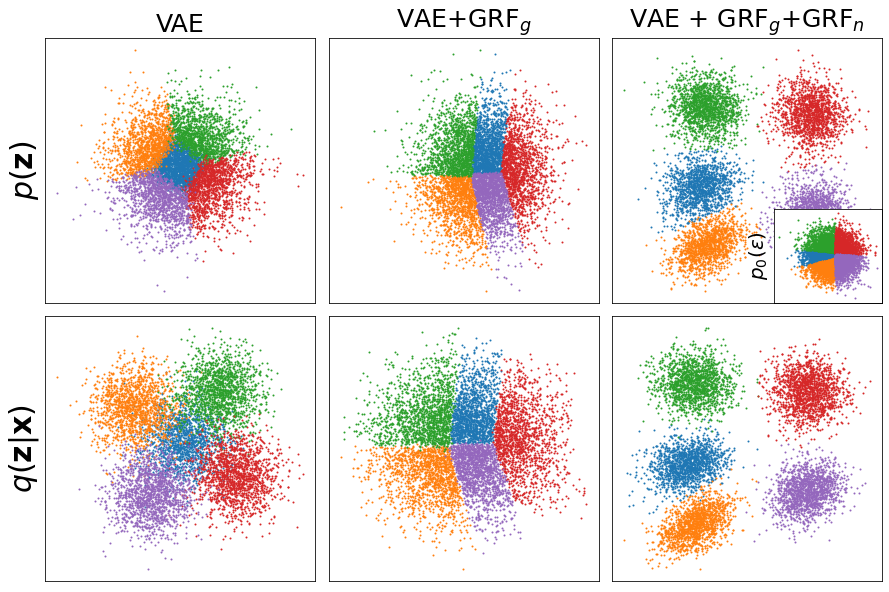

In [24]:
# Plot latent space
path = './experiment_logs/SIReN-VAE_flow_effect/onehot/'
plt.rcParams.update({'font.size': 21})
fig, ax = plt.subplots(2,3, figsize=(15,10))#, sharex=True, sharey=True)
N = 7500
X = load_onehot(N).double().to(device)
colours = ['red', 'blue', 'orange']

#### VAE ####
model = set_model(torch.load(path+'VAE/1/model.pt', map_location=torch.device(device)), True, device)
# Prior
Xgen, Z = model.sample(N)
for i in range(5):
    Zi = Z[torch.argmax(Xgen,dim=1)==i,:].detach().cpu().numpy()
    ax[0,0].scatter(Zi[:,0],Zi[:,1], s=1.)
ax[0,0].set_ylabel(r'$p(\mathbf{z})$', fontsize=30)
ax[0,0].set_title('VAE')

# Posterior
for i in range(5):
    Xi = X[X[:,i]==1.0,:]
    Z, _ = model.inference_network(Xi)
    Z = Z.detach().cpu().numpy()
    ax[1,0].scatter(Z[:,0],Z[:,1], s=1.)
ax[1,0].set_ylabel(r'$q(\mathbf{z}|\mathbf{x})$', fontsize=30)

# #### VAE + GRF posterior ####
model = set_model(torch.load(path+'VAE_GRF-post/1/model.pt', map_location=torch.device(device)), True, device)
# Prior
Xgen, Z = model.sample(N)
for i in range(5):
    Zi = Z[torch.argmax(Xgen,dim=1)==i,:].detach().cpu().numpy()
    ax[0,1].scatter(Zi[:,0],Zi[:,1], s=1.)
ax[0,1].set_title(r'VAE+GRF$_g$')
# Posterior
for i in range(5):
    Xi = X[X[:,i]==1.0,:]
    Z, _ = model.inference_network(Xi)
    Z = Z.detach().cpu().numpy()
    ax[1,1].scatter(Z[:,0],Z[:,1], s=1.)

# #### VAE + GRF posterior + GRF prior ###
model = set_model(torch.load(path+'VAE_GRF-post_GRF-prior/1/model.pt', map_location=torch.device(device)), True, device) 
# Prior
Xgen, Z = model.sample(N)
for i in range(5):
    Zi = Z[torch.argmax(Xgen,dim=1)==i,:].detach().cpu().numpy()
    ax[0,2].scatter(Zi[:,0],Zi[:,1], s=1.)
ax[0,2].set_title(r'VAE + GRF$_g$+GRF$_n$')

axm = fig.add_axes([0.8, 0.512, 0.1, 0.13])
for i in range(5):
    Zi = Z[torch.argmax(Xgen,dim=1)==i,:]
    Ei,_ = model.generative_network.nf(Zi)
    Ei = Ei.detach().cpu().numpy()
    axm.scatter(Ei[:,0],Ei[:,1], s=1.)
axm.axes.xaxis.set_visible(False)
axm.set_yticks([])
axm.set_ylabel(r'$p_0(\epsilon)$', fontsize=20)

# Posterior
for i in range(5):
    Xi = X[X[:,i]==1.0,:]
    Z, _ = model.inference_network(Xi)
    Z = Z.detach().cpu().numpy()
    ax[1,2].scatter(Z[:,0],Z[:,1], s=1.) 
    

for i in range(2):
    for j in range(3):
        #ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].set_yticks([]) 
        ax[i,j].axes.xaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/onehot.png', dpi=600, bbox_inches='tight')
plt.show() 

In [8]:
# Models
path = './experiment_logs/SIReN-VAE_flow_effect/onehot/'
models = [
    ['VAE', 'VAE/1/model.pt'],
    ['VAE + GRF posterior', 'VAE_GRF-post/1/model.pt'],
    ['VAE + GRF posterior + GRF Prior', 'VAE_GRF-post_GRF-prior/1/model.pt']           
]

In [9]:
# Log-likelihood
print('Estimated log p(x)')
X = load_onehot(500).to(device)
for m, p in models:
    model = load_model(path+p, device, False) 
    attach_bernoulli_forward(model)
    log_px = torch.mean(model.importance_sampled_log_likelihood(X, 50))
    print('{:>31}: {:.5f}'.format(m, log_px.item()))

Estimated log p(x)
                            VAE: -1.89953
            VAE + GRF posterior: -1.66178
VAE + GRF posterior + GRF Prior: -1.62910


In [10]:
# Reconstruction Error
print('Reconstruction Error')
X = load_onehot(500).to(device)
for m, p in models:
    model = load_model(path+p, device, False) 
    z, _ = model.inference_network(X)
    params = model.generative_network.decoder_net(z)
    X_prime = torch.sigmoid(params)
    re = torch.norm(X-X_prime, dim=1).mean()
    # loss = torch.nn.MSELoss()
    # re = loss(X_prime, X)
    print('{:>31}: {:.5f}'.format(m, re.item()))

Reconstruction Error
                            VAE: 0.24535
            VAE + GRF posterior: 0.04287
VAE + GRF posterior + GRF Prior: 0.00928


## MNIST Dataset

In [ ]:
# Train Vanilla VAE
! python ./ex_siren_vae_flow_effect.py with dataset=mnist lr=1e-3 num_epochs=500 num_latent=128 patience=20 vae_hidden_dims='[256,512]' num_blocks=5 num_train_samples=50000 num_val_samples=10000

In [ ]:
# train VAE + GRF Posterior
! python ./ex_siren_vae_flow_effect.py with dataset=mnist lr=1e-3 num_epochs=500 num_latent=128 patience=20 vae_hidden_dims='[256,512]' num_blocks=5 num_train_samples=50000 num_val_samples=10000 flow_hidden_dims='[500]' add_grf_posterior=True

In [ ]:
# train VAE + GRF Posterior + GRF Prior
! python ./ex_siren_vae_flow_effect.py with dataset=mnist lr=1e-3 num_epochs=500 num_latent=128 patience=20 vae_hidden_dims='[256,512]' num_blocks=5 num_train_samples=50000 num_val_samples=10000 add_grf_posterior=True add_grf_prior=True flow_hidden_dims='[500]' fc_bn=True indep_bn=False seed=1

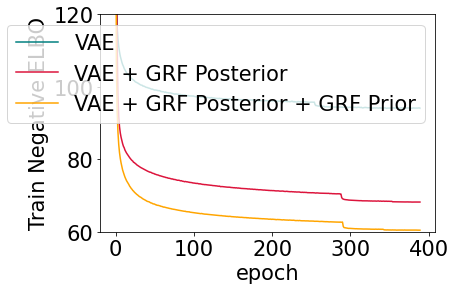

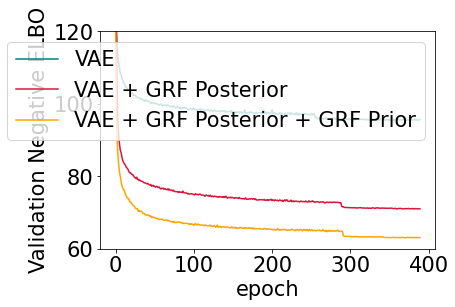

In [28]:
# Plot loss
elbo_curves(
    experiments=[
        'SIReN-VAE_flow_effect/mnist/VAE/',
        'SIReN-VAE_flow_effect/mnist/VAE_GRF-post/',
        'SIReN-VAE_flow_effect/mnist/VAE_GRF-post_GRF-prior/'
    ],
    legend=['VAE', 'VAE + GRF Posterior', 'VAE + GRF Posterior + GRF Prior'],
    _config={
        'num_runs':1,
        'iter':390,
        'ylims':[(60, 120)],
        'log_scale':False,
        'palette':('teal','crimson', 'orange', 'darkslateblue', 'slateblue')})

### Generate Samples

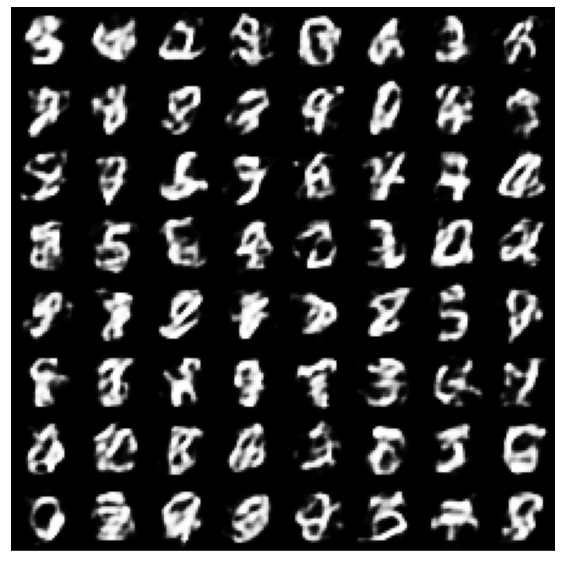

In [29]:
# generate samples
# Samples
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(10,10))

#### VAE ####
model = torch.load(path+'VAE/1/model.pt', map_location=torch.device(device)).float().to(device)
model.inference_network.device = device
model.generative_network.device = device
attach_bernoulli_forward(model)
attach_bernoulli_sample(model)
model.eval()
N = 8
Xgen, _ = model.generative_network.sample(N**2)
img = np.zeros((N*28,N*28))
Xgen = Xgen.detach().cpu()
for i in range(N):
    for j in range(N):
        img[i*28:i*28+28,j*28:j*28+28] = Xgen[i*N+j].reshape(28,28)
ax.imshow(img, cmap='gray')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False) 
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/mnist_samples_vae.png', dpi=600, bbox_inches='tight')
plt.show() 

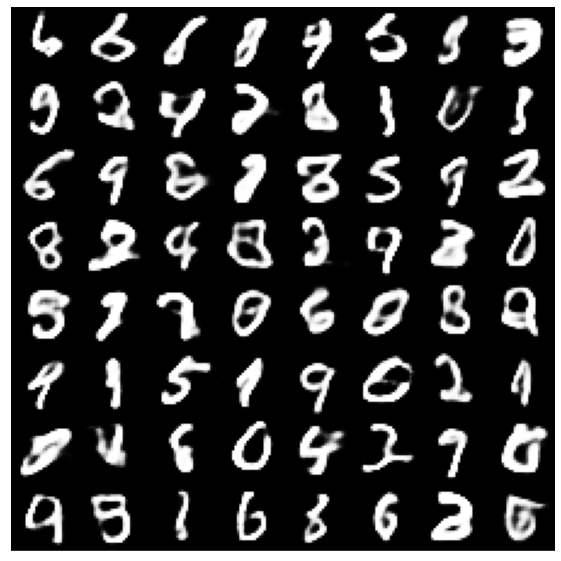

In [30]:
# # #### VAE + GRF Posterior ####
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(10,10))

model = torch.load(path+'VAE_GRF-post/1/model.pt', map_location=torch.device(device)).float().to(device)
model.inference_network.device = device
model.generative_network.device = device
attach_bernoulli_forward(model)
attach_bernoulli_sample(model)
N = 8
Xgen, _ = model.generative_network.sample(N**2)
img = np.zeros((N*28,N*28))
Xgen = Xgen.detach().cpu()
for i in range(N):
    for j in range(N):
        img[i*28:i*28+28,j*28:j*28+28] = Xgen[i*N+j].reshape(28,28)
ax.imshow(img, cmap='gray')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False) 
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/mnist_samples_vae_grf-posterior.png', dpi=600, bbox_inches='tight')
plt.show() 

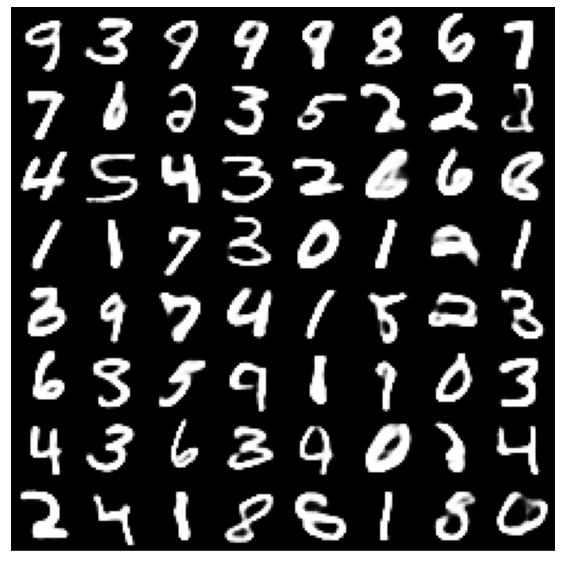

In [31]:
#### VAE + GRF Posterior + GRF Prior ####
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(10,10))

model = torch.load(path+'VAE_GRF-post_GRF-prior/1/model.pt', map_location=torch.device(device)).float().to(device)
model.inference_network.device = device
model.generative_network.device = device
N = 8
attach_bernoulli_forward(model)
attach_bernoulli_sample(model)
Xgen, _ = model.generative_network.sample(N**2)
img = np.zeros((N*28,N*28))
Xgen = Xgen.detach().cpu()
for i in range(N):
    for j in range(N):
        img[i*28:i*28+28,j*28:j*28+28] = Xgen[i*N+j].reshape(28,28)
ax.imshow(img, cmap='gray')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False) 
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/mnist_samples_vae_grf-posterior_grf-prior.png', dpi=600, bbox_inches='tight')
plt.show() 

### TSNE Plots

In [9]:
# Load data
_, X = load_binary_mnist()
batcher = DataLoader(X, batch_size=1750)
X,y = next(iter(batcher))
X = X.to(device)
del batcher

Loading binary MNIST:
Data dimension:  784
Train dataset size:  60000
Test dataset size:  10000


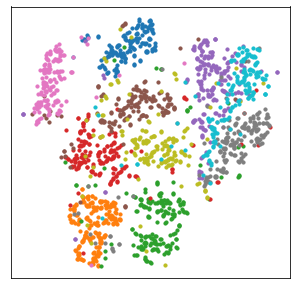

In [35]:
#### Data ####
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1, figsize=(5,5), )
X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(X.cpu())
for i in range(10):
    Xi = X_embedded[y==i,:]
    ax.scatter(Xi[:,0],Xi[:,1], s=10.)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/mnist_tsne_data.png', dpi=600, bbox_inches='tight')

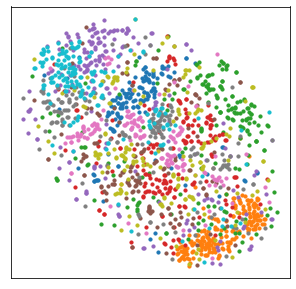

In [36]:
# VAE
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1, figsize=(5,5))
model = torch.load(path+'VAE/1/model.pt', map_location=torch.device(device)).float().to(device)
model.eval()
with torch.no_grad():
    Z, _ = model.inference_network(X)
    Z = Z.cpu()
    Z_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(Z)
for i in range(10):
    Zi = Z_embedded[y==i,:]
    ax.scatter(Zi[:,0],Zi[:,1], s=10.)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/mnist_tsne_vae.png', dpi=600, bbox_inches='tight')
del model, Z, Z_embedded

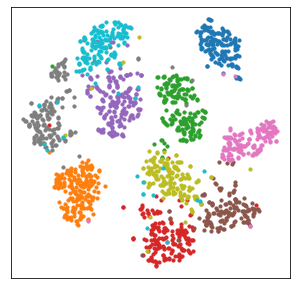

In [10]:
# SIReN-VAE
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1, figsize=(5,5))
model = torch.load(path+'VAE_GRF-post_GRF-prior/1/model.pt', map_location=torch.device(device)).float().to(device)
model.eval()
with torch.no_grad():
    Z, _ = model.inference_network(X)
    Z = Z.cpu()
    Z_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(Z)
for i in range(10):
    Zi = Z_embedded[y==i,:]
    ax.scatter(Zi[:,0],Zi[:,1], s=10.)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig('./experiment_logs/figures/siren-vae_flow_effect/mnist_tsne_siren-vae.png', dpi=600, bbox_inches='tight')
del model, Z, Z_embedded

### FID Scores

In [11]:
#### VAE- save samples
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
model = torch.load(path+'VAE/1/model.pt', map_location=torch.device(device)).float().to(device)
model.inference_network.device = device
model.generative_network.device = device
attach_bernoulli_forward(model)
attach_bernoulli_sample(model)
model.eval()
Xgen, _ = model.generative_network.sample(3000)
for i in range(Xgen.shape[0]):
    save_image(Xgen[i].reshape(28,28), './experiment_logs/SIReN-VAE_flow_effect/mnist/VAE/MNIST_samples/{}.png'.format(i))

In [12]:
### FID Scores - VAE ####
# From: https://github.com/mseitzer/pytorch-fid
%run -m pytorch_fid './experiment_logs/SIReN-VAE_flow_effect/mnist/MNIST_samples' './experiment_logs/SIReN-VAE_flow_effect/mnist/VAE/MNIST_samples'

100%|██████████| 60/60 [00:06<00:00,  9.67it/s]


FID:  120.20186247987925


In [13]:
#### VAE + GRF-posterior - save samples
model = torch.load(path+'VAE_GRF-post/1/model.pt', map_location=torch.device(device)).float().to(device)
model.inference_network.device = device
model.generative_network.device = device
attach_bernoulli_forward(model)
attach_bernoulli_sample(model)
model.eval()
Xgen, _ = model.generative_network.sample(3000)
for i in range(Xgen.shape[0]):
    save_image(Xgen[i].reshape(28,28), './experiment_logs/SIReN-VAE_flow_effect/mnist/VAE_GRF-post/MNIST_samples/{}.png'.format(i))

In [14]:
### FID Scores - VAE + GRF-posterior ####
%run -m pytorch_fid './experiment_logs/SIReN-VAE_flow_effect/mnist/MNIST_samples' './experiment_logs/SIReN-VAE_flow_effect/mnist/VAE_GRF-post/MNIST_samples'

100%|██████████| 60/60 [00:06<00:00,  9.69it/s]


FID:  111.52115867842994


In [15]:
#### VAE + GRF-posterior + GRF Prior - save samples
model = torch.load(path+'VAE_GRF-post_GRF-prior/1/model.pt', map_location=torch.device(device)).float().to(device)
model.inference_network.device = device
model.generative_network.device = device
attach_bernoulli_forward(model)
attach_bernoulli_sample(model)
model.eval()
Xgen, _ = model.generative_network.sample(3000)
for i in range(Xgen.shape[0]):
    save_image(Xgen[i].reshape(28,28), './experiment_logs/SIReN-VAE_flow_effect/mnist/VAE_GRF-post_GRF-prior/MNIST_samples/{}.png'.format(i))

In [16]:
### FID Scores - VAE + GRF-posterior ####
%run -m pytorch_fid './experiment_logs/SIReN-VAE_flow_effect/mnist/MNIST_samples' './experiment_logs/SIReN-VAE_flow_effect/mnist/VAE_GRF-post_GRF-prior/MNIST_samples'

100%|██████████| 60/60 [00:06<00:00,  9.62it/s]


FID:  99.47921259444271


### Other Metrics

In [17]:
# Models
path = './experiment_logs/SIReN-VAE_flow_effect/mnist/'
models = [
    ['VAE', 'VAE/1/model.pt'],
    ['VAE + GRF posterior', 'VAE_GRF-post/1/model.pt'],
    ['VAE + GRF posterior + GRF Prior', 'VAE_GRF-post_GRF-prior/1/model.pt']           
]

In [18]:
# Log-likelihood
print('Estimated log p(x)')
_, X = load_binary_mnist()
batcher = DataLoader(X, batch_size=10000)
X,y = next(iter(batcher))
del batcher
with torch.no_grad():
    for m, p in models:
        model = torch.load(path+p, map_location=torch.device(device)).float().to(device) 
        model.inference_network.device = device
        model.generative_network.device = device
        if isinstance(model.inference_network, XencodingInferNetwork):
            model.inference_network.infer_network.nf.device = device
        attach_bernoulli_forward(model)
        attach_bernoulli_sample(model)
        log_px = importance_sampled_log_likelihood(model, X, k=50, batch_size=2, device=device)
        print('{:>31}: {:.5f}'.format(m, log_px.item()))

Estimated log p(x)
Loading binary MNIST:
Data dimension:  784
Train dataset size:  60000
Test dataset size:  10000
                            VAE: -82.26196
            VAE + GRF posterior: -65.57415
VAE + GRF posterior + GRF Prior: -59.41444


In [19]:
# Reconstruction Error
print('Reconstruction Error')
_, X = load_binary_mnist()
batcher = DataLoader(X, batch_size=500)
for m, p in models:
    model = torch.load(path+p, map_location=torch.device(device))
    model.inference_network.device = device
    model.generative_network.device = device
    if isinstance(model.inference_network, XencodingInferNetwork):
        model.inference_network.infer_network.nf.device = device
    attach_bernoulli_forward(model)
    attach_bernoulli_sample(model)
    re = 0
    for batch in batcher:
        x = batch[0].to(device)
        z, _ = model.inference_network(x)
        params = model.generative_network.decoder_net(z)
        X_prime = torch.sigmoid(params)
        re += torch.norm(x-X_prime, dim=1).mean().item()
    print('{:>31}: {:.5f}'.format(m, re/(10000/500)))

Reconstruction Error
Loading binary MNIST:
Data dimension:  784
Train dataset size:  60000
Test dataset size:  10000
                            VAE: 3.86994
            VAE + GRF posterior: 3.25201
VAE + GRF posterior + GRF Prior: 3.04275
